In [1]:
import lsst.afw.table as afwTable
import lsst.afw.image as afwImage
import lsst.afw.detection as afwDet
from lsst.meas.algorithms import SourceDetectionTask, SourceDetectionConfig
from lsst.meas.algorithms.installGaussianPsf import InstallGaussianPsfTask
from lsst.meas.base import SingleFrameMeasurementTask, SingleFrameMeasurementConfig
from lsst.meas.deblender import SourceDeblendTask
from lsst.ip.isr.isrFunctions import updateVariance
import lsst.afw.geom as afwGeom
from lsst.afw.math import BackgroundList
from lsst.pipe.tasks.calibrate import CalibrateTask, CalibrateConfig
from lsst.pipe.tasks.characterizeImage import CharacterizeImageTask, CharacterizeImageConfig

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import seaborn as sns

plt.style.use('seaborn-poster')

In [ ]:
#first we need to read in the simulation and prepare the variance plane
#we will skip ISR and cosmic ray rejection because we are dealing with idealized
#simulated data
im = afwImage.ImageF.readFits('SkyEstimation/SET6_variousPSF_DLSlikeNew_sky3240_stack.fits')
exposure = afwImage.ExposureF(im.getBBox())
exposure.setImage(im)
gain = 3.0
readNoise = 0
updateVariance(exposure.getMaskedImage(), gain, readNoise)

In [20]:
#do the characterize image task. set a few configs that are specific to 
#the data
charConfig = CharacterizeImageConfig()
#this set the fwhm of the simple PSF to that of the fwhm used in the simulation
charConfig.installSimplePsf.fwhm = .9/.26
charConfig.doApCorr = False
charConfig.doMeasurePsf = False
charConfig.repair.doCosmicRay = False
#we want 50x50 bins for the background. 
charConfig.detection.background.binSize = 161
charConfig.background.binSize = 161
charConfig.detection.minPixels = 6
charTask = CharacterizeImageTask(config=charConfig)

charResult = charTask.characterize(exposure)

In [34]:
#perform calibrate task. no need to do astrometry or photomoetry calibration
#since this is a simulation
calConfig = CalibrateConfig()
calConfig.doAstrometry = False
calConfig.doPhotoCal = False
calConfig.detection.minPixels = 6
calConfig.doApCorr = False
calConfig.detection.background.binSize = 161
calTask = CalibrateTask(config= calConfig, icSourceSchema=charResult.sourceCat.schema)
calResult = calTask.calibrate(charResult.exposure, background=charResult.background,
                              icSourceCat = charResult.sourceCat)

In [22]:
#calculate the magnitudes of the deblended sources
#we take the flux from the footprints of detected sources to do this.
#open to using other method to calculating magnitudes

sourceCat = calResult.sourceCat.copy(deep=True)
#avoid double counting sources that were deblended
noChildren = sourceCat['deblend_nChild'] == 0
subSourceCat = sourceCat.subset(noChildren)
Ndetected = len(subSourceCat)
mag_array = np.zeros(Ndetected)

mi = calResult.exposure.getMaskedImage()

m0 = 32.73 #magnitude zero point

for i in range(0,Ndetected):
    fp = subSourceCat[i].getFootprint()
    heavy = afwDet.makeHeavyFootprint(fp, mi)
    flux = heavy.getImageArray().sum()
    mag = m0 - 2.5*np.log10(flux)
    mag_array[i] = mag

    
#mask out the nan magnitudes.
mag_array = mag_array[~np.isnan(mag_array)]

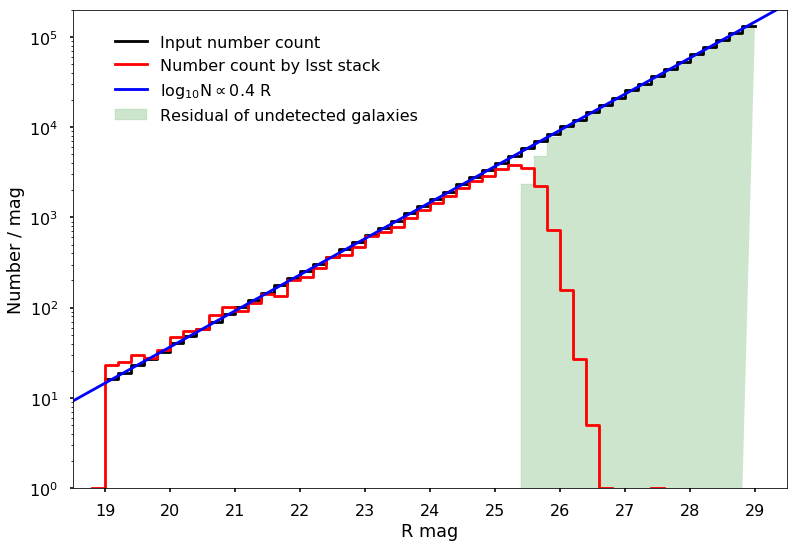

In [23]:
#find how good a job detection did in getting galaxies that were injected into the sim
#this snippit is courtesy of Inchan Ji
binsize = 0.2
minval = 18.; maxval = 29.
histrange = [minval, maxval]
nbins  = int((maxval - minval)/ binsize)

mags = np.genfromtxt('SkyEstimation/input_mags.txt')
val = mags
bins, edges = np.histogram(val, nbins,range = histrange)
left, right = edges[:-1],edges[1:]
X0 = np.array([left,right]).T.flatten();
Y0 = np.array([bins,bins]).T.flatten()
Xdata0 = X0[::2] + 0.5 * (X0[1]-X0[0]); Ydata0 = Y0[::2]
X0 = np.concatenate((X0,[29.]))
Y0 = np.concatenate((Y0,[0]))

val = mag_array
bins, edges = np.histogram(val, nbins,range = histrange)
left, right = edges[:-1],edges[1:]
X1 = np.array([left,right]).T.flatten();
Y1 = np.array([bins,bins]).T.flatten()
Xdata1 = X1[::2] + 0.5 * (X1[1]-X1[0]); Ydata1 = Y1[::2]
X1 = np.concatenate((X1,[29.]))
Y1 = np.concatenate((Y1,[0]))

Residual = Y0 - Y1

x = np.linspace(18.5,29.5,100)

plt.plot(X0,Y0,'k-',label = 'Input number count')
plt.plot(X1,Y1,'r-', label = 'Number count by lsst stack')
plt.plot(x,10.**(0.4*x - 6.4347),'b-',label = '$\mathregular{log_{10}N \propto 0.4\ R}$')

plt.fill_between(X0[X0>=25.4], Residual[X0>=25.4], 1e-90 *np.ones(X0[X0>=25.4].size),\
                 color='green',\
                 alpha = 0.2,label='Residual of undetected galaxies')
plt.yscale('log', nonposy='clip')
plt.xlim(18.5,29.5)
plt.ylim(1,2.e5)
plt.yscale('log')
plt.ylabel('Number / mag')
plt.xlabel('R mag')
plt.legend(frameon=False, loc = [0.05,0.75])
plt.xticks([19,20,21,22,23,24,25,26,27,28,29])
plt.show()

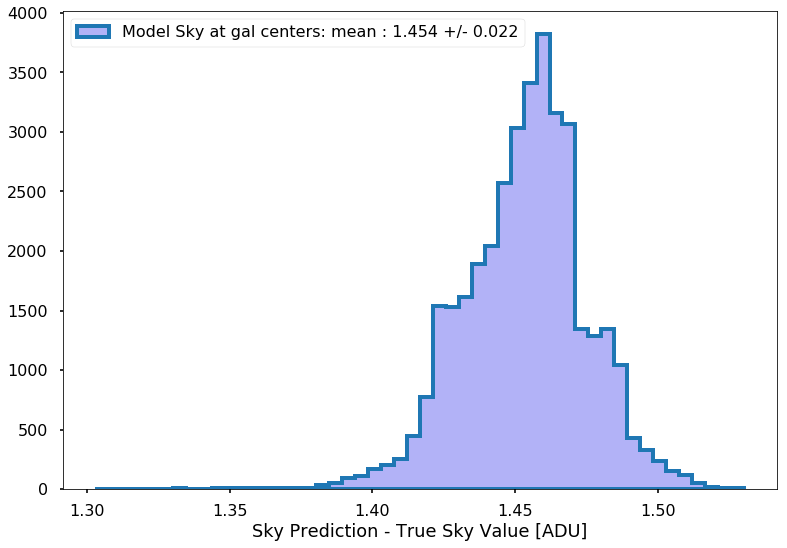

In [50]:
#lets plot up the background values at the centers of detected galaxies
calResultCat = calResult.sourceCat.copy(deep=True)
centroids = np.array([np.around(calResultCat['base_SdssCentroid_y']).astype('int'),
          np.around(calResultCat['base_SdssCentroid_x']).astype('int')]).T

bgVals = calResult.background.getImage().array[centroids[:,0], centroids[:,1]]

a =plt.hist(bgVals, bins=50, histtype='stepfilled', lw=4, label = 'Model Sky at gal centers: mean : %.3f +/- %.3f'
               %(bgVals.mean(), bgVals.std()), facecolor=(0,0,.9,.3), edgecolor='C0')
plt.xlabel('Sky Prediction - True Sky Value [ADU]/Pixel')
plt.legend(loc='upper left')
plt.show()

In [ ]:
Rmaglist = X0[X0>25.9][::2][1:] - 0.1  # 0.1 : to shift R mag to the center of each bin
Ngallist = Residual[X0>25.9][::2][1:]
print('R mag of undetected galaxies:\n', Rmaglist)
print('The number of undetected galaxies in each mag bin:\n', Ngallist)
Rmaglist = np.array(Rmaglist); Ngallist = np.array(Ngallist,dtype='float')

In [ ]:
Modellist = ['mygalR24_avg.fits', 'mygalR25_avg.fits', \
             'mygalR26_avg.fits','mygalR27_avg.fits',\
             'mygalR28_avg.fits','mygalR29_avg.fits']

HistFac  =  (80./8000.)**2.
Ngallist *=  HistFac # normalize amplitdue for a 80 by 80 pixel region

In [ ]:
Ngallist

In [ ]:
HistUGalsPix0 = []; HistUGalsPix = [];
for i in range(len(Rmaglist)):
    Rmag = int(round(Rmaglist[i]))
    filename = 'mygalR'+str(Rmag)+'_avg.fits'
    hdu = fits.open('SkyEstimation/'+filename)
    prof0 = hdu[0].data.ravel() 

    Ftot = 10.**((m0-Rmaglist[i])/2.5)
    prof0 = prof0 * Ftot
    
    prof0 = prof0[prof0 > 0.81] # Note : 0.81 ADU ~ 30 mag / arcsec^2
    mu = 0.; cnt = 0.
    for j in range(int(Ngallist[i])):
        mu += np.sum(prof0); cnt += len(prof0)
        HistUGalsPix0 += list(prof0)
        
HistUGalsPix0 = np.array(HistUGalsPix0)

In [ ]:
data = np.random.normal(0, scale = 12.73, size = 80**2)

binsize = 3.5 * np.std(data) *  len(data) **(-0.33333333) * 1. 
print(binsize) # typical binsize of pure gaussian noise in 80 by 80 pixels 
              # but it will change depending on position.

In [ ]:
fontsize  = 15

fig = plt.figure(0,figsize = (6,5))


binsize = 2.4

histrange = [0-binsize*0.5, binsize*20+0.5*binsize]

nbins = int((histrange[1] - histrange[0]) / binsize)
bins, edges = np.histogram(HistUGalsPix0, nbins,range = histrange) # 30 mag / arcsec^2
left, right = edges[:-1],edges[1:]
X = np.array([left,right],dtype = 'float').T.flatten(); 
Y = np.array([bins,bins],dtype = 'float').T.flatten();
X = np.concatenate(([X[0]],X))
Y = np.concatenate(([0],Y))
plt.plot(X,Y,'b-', \
        label = 'Pixels ($\mathregular{<\ 30\ mag\ arcsec^{-2}}$) before sky noise')


sky   = 0.
noise = 12.73
Nstack  = 20.
x = np.linspace(-50,70,1000)

for i in range(len(X)):
    amp = Y[i] * binsize    
    sig = np.sqrt(noise**2. + X[i]**2. / Nstack)    
    if i == 0:
        y = amp / np.sqrt(2. * np.pi) / sig * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)
        plt.plot(x,y,'g-',label = 'Pixels after sky noise in each bin',linewidth = 1.5)
    else:
        y += amp / np.sqrt(2. * np.pi) / sig * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig)
        plt.plot(x, amp / np.sqrt(2. * np.pi) / sig \
                 * np.exp(-0.5 * (x - sky - X[i])**2./sig/sig),'g-',linewidth = 1.5)

plt.plot(x,y,'r-',label = 'All pixels combined after sky noise = local EBL')

plt.ylabel('Number',size = fontsize)
plt.xlabel('Pixel value [ADU]',size = fontsize)
plt.xlim(-40,40)
#plt.ylim(0,1050)

plt.legend(frameon=False, loc = [0.02,0.8])
plt.tick_params(axis='both', labelsize=fontsize-3)   

plt.show()

In [ ]:
np.isnan(np.nan)